In [3]:
import MDAnalysis
import numpy as np
from DEERpredict.PRE import PREpredict
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from scipy.optimize import minimize_scalar, least_squares

Example of how to run PREpredict to calculate the intensity ratios and PRE rates for PDB 1NTI (20 conformations) using the rotamer-library approach (`Cbeta = False`)

In [4]:
!mkdir calcPREs
!mkdir figs

mkdir: calcPREs: File exists
mkdir: figs: File exists


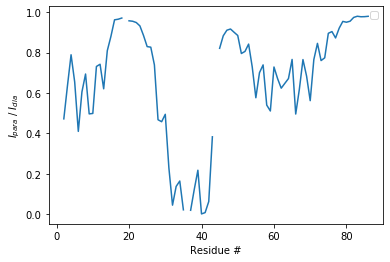

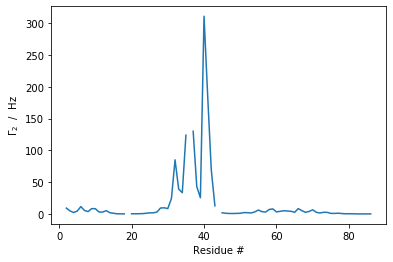

In [5]:
PRE = PREpredict(MDAnalysis.Universe('1nti.pdb'), residue = 36, output_prefix = 'calcPREs/res', weights = False,
      load_file = False, tau_t = .5*1e-9, log_file = 'calcPREs/log', delay = 10e-3,
      tau_c = 2*1e-09, k = 1.23e16, r_2 = 10, temperature = 298, Z_cutoff = 0.2, Cbeta = False,
      atom_selection = 'H', wh = 750)
PRE.run()

resnums, PREratios, PRErates = np.loadtxt('calcPREs/res-{:d}.dat'.format(36),unpack=True)
plt.plot(resnums, PREratios)
plt.ylabel('$I_{para}$ / $I_{dia}$')
plt.xlabel('Residue #')
plt.legend()
plt.show()

plt.plot(resnums, PRErates)
plt.ylabel('$\Gamma_2$  /  Hz')
plt.xlabel('Residue #')
plt.show()

In [6]:
u = MDAnalysis.Universe('1nti.pdb')
u.select_atoms('name {} and protein'.format('N'))

<AtomGroup with 86 atoms>

In [11]:
def load_calcPREs(path,labels):
    data = {}
    for label in labels:
        resnums, data[label], _ = np.loadtxt(path+'/res-{:d}.dat'.format(label),unpack=True)
    df = pd.DataFrame(data, index=resnums)
    df.rename_axis('residue', inplace=True)
    df.rename_axis('label', axis='columns',inplace=True)
    return resnums, df

def calcIratio(tau_c,args):
    u, label, tau_t, r_2, Cbeta = args
    PRE = PREpredict(u, label, output_prefix = 'calcPREs/res', weights = False,
          load_file = False, tau_t = tau_t*1e-9, log_file = 'calcPREs/log', delay = 10e-3,
          tau_c = tau_c*1e-09, k = 1.23e16, r_2 = r_2, temperature = 298, Z_cutoff = 0.2, Cbeta = Cbeta,
          atom_selection = 'H', wh = 750)
    PRE.run()

def calcIratioDynRange(tau_c,args):
    u, label, tau_t, r_2, Cbeta = args
    PRE = PREpredict(u, label, output_prefix = 'calcPREs/res', weights = False,
          load_file = False, tau_t = tau_t*1e-9, log_file = 'calcPREs/log', delay = 10e-3,
          tau_c = tau_c*1e-09, k = 1.23e16, r_2 = r_2, temperature = 298, Z_cutoff = 0.2, Cbeta = Cbeta,
          atom_selection = 'H', wh = 750)
    PRE.run()

In [12]:
labels = [17,36,46,65,86]

In [13]:
%%timeit
calcIratio(2,[u, 17, 0.2, 12.6, False])

461 ms ± 13 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


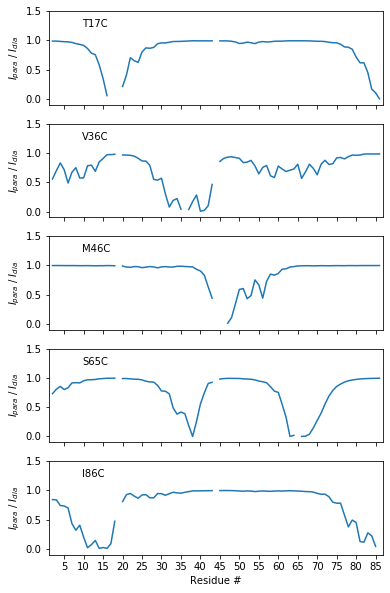

In [14]:
fig, axes = plt.subplots(len(labels), 1, sharex=True, sharey=False, figsize=(6,10))

for ax,label,res in zip(axes.flatten(),labels,'TVMSI'):
    calcIratio(2,[u, label, 0.2, 12.6, False])
    calcPREs = np.loadtxt('calcPREs/res-{:d}.dat'.format(label))[:,1]
    ax.plot(resnums, calcPREs)
    ax.annotate(res+str(label)+'C',xy=(.1,.83),xycoords='axes fraction')
    ax.set_ylabel('$I_{para}$ / $I_{dia}$')
    ax.set_ylim(-.1,1.5)
    ax.set_xlim(1,resnums.size+1)
    ax.set_xticks(range(0,resnums.size+1,5)[1:])
axes.flatten()[-1].set_xlabel('Residue #')
plt.savefig('figs/fig4.pdf')

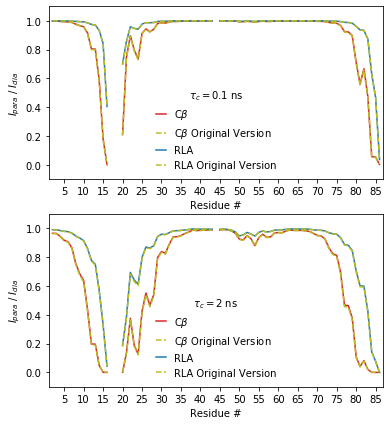

In [15]:
fig, (ax1,ax2) = plt.subplots(2, 1, sharex=False, sharey=False, figsize=(6,7))

label=17

calcIratio(0.1,[u, label, 0.1, 12.6, True])
calcPREs = np.loadtxt('calcPREs/res-{:d}.dat'.format(label))[:,1]
ax1.plot(resnums, calcPREs, color=plt.cm.tab10(3), label=r'C$\beta$')

calcPREs = np.loadtxt('precalcPREs/PRE_1nti_0.1-{:d}_CB.dat'.format(label))[:,1]
ax1.plot(resnums, calcPREs, color=plt.cm.tab10(8), ls='--', label=r'C$\beta$ Original Version')

calcIratio(0.1,[u, label, 0.1, 12.6, False])
calcPREs = np.loadtxt('calcPREs/res-{:d}.dat'.format(label))[:,1]
ax1.plot(resnums, calcPREs, color=plt.cm.tab10(0), label='RLA')

calcPREs = np.loadtxt('precalcPREs/PRE_1nti_0.1-{:d}.dat'.format(label))[:,1]
ax1.plot(resnums, calcPREs, color=plt.cm.tab10(8), ls='--', label=r'RLA Original Version')

ax1.legend(frameon=False,title=r'$\tau_c=0.1$ ns',handlelength=1)

calcIratio(2,[u, label, 0.5, 12.6, True])
calcPREs = np.loadtxt('calcPREs/res-{:d}.dat'.format(label))[:,1]
ax2.plot(resnums, calcPREs, color=plt.cm.tab10(3), label=r'C$\beta$')

calcPREs = np.loadtxt('precalcPREs/PRE_1nti_2-{:d}_CB.dat'.format(label))[:,1]
ax2.plot(resnums, calcPREs, color=plt.cm.tab10(8), ls='--', label=r'C$\beta$ Original Version')

calcIratio(2,[u, label, 0.5, 12.6, False])
calcPREs = np.loadtxt('calcPREs/res-{:d}.dat'.format(label))[:,1]
ax2.plot(resnums, calcPREs, color=plt.cm.tab10(0), label='RLA')

calcPREs = np.loadtxt('precalcPREs/PRE_1nti_2-{:d}.dat'.format(label))[:,1]
ax2.plot(resnums, calcPREs, color=plt.cm.tab10(8), ls='--', label=r'RLA Original Version')

ax2.legend(frameon=False,title=r'$\tau_c=2$ ns',handlelength=1)

for ax in [ax1,ax2]:
    ax.set_ylabel('$I_{para}$ / $I_{dia}$')
    ax.set_ylim(-.1,1.1)
    ax.set_xlim(1,resnums.size+1)
    ax.set_xticks(range(0,resnums.size+1,5)[1:])
    ax.set_xlabel('Residue #')
plt.savefig('figs/fig5.pdf')
plt.show()

# Influence of $\tau_C$ on $\chi^2$

In [50]:
!mkdir chi2tau_c

mkdir: chi2tau_c: File exists


In [52]:
for label in labels:
    chi2 = []
    for tau_c in np.arange(.1,8,.1):
        chi2.append(calcIratio(tau_c, [u, label, 0.5, 12.6,  False]))
    np.savetxt('chi2tau_c/chi2RLA{:d}.dat'.format(label),np.c_[np.arange(.1,8,.1),chi2])

for label in labels:
    chi2 = []
    for tau_c in np.arange(.1,8,.1):
        chi2.append(calcIratioDynRange(tau_c, [u, label, 0.5, 12.6,  False]))
    np.savetxt('chi2tau_c/chi2RLADynRange{:d}.dat'.format(label),np.c_[np.arange(.1,8,.1),chi2])

for label in labels:
    chi2 = []
    for tau_c in np.arange(.1,8,.1):
        chi2.append(calcIratio(tau_c, [u, label, 0.5, 12.6,  True]))
    np.savetxt('chi2tau_c/chi2Cbeta{:d}.dat'.format(label),np.c_[np.arange(.1,8,.1),chi2])

for label in labels:
    chi2 = []
    for tau_c in np.arange(.1,8,.1):
        chi2.append(calcIratioDynRange(tau_c, [u, label, 0.5, 12.6,  True]))
    np.savetxt('chi2tau_c/chi2CbetaDynRange{:d}.dat'.format(label),np.c_[np.arange(.1,8,.1),chi2])

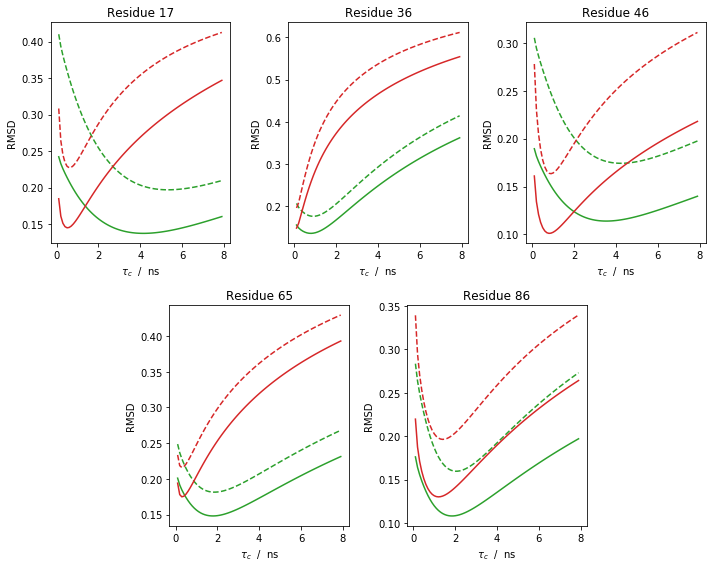

In [58]:
ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2, fig=plt.figure(figsize=(10,8)))
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)
axes = [ax1,ax2,ax3,ax4,ax5]
for ax,label in zip(axes,labels):
    tau_c,chi2 = np.loadtxt('chi2tau_c/chi2RLA{:d}.dat'.format(label),unpack=True)
    ax.plot(tau_c,np.sqrt(chi2), color=plt.cm.tab10(2), label='RLA')
    tau_c,chi2 = np.loadtxt('chi2tau_c/chi2RLADynRange{:d}.dat'.format(label),unpack=True)
    ax.plot(tau_c,np.sqrt(chi2), color=plt.cm.tab10(2), ls='--', label='RLA dyn. range')
    tau_c,chi2 = np.loadtxt('chi2tau_c/chi2Cbeta{:d}.dat'.format(label),unpack=True)
    ax.plot(tau_c,np.sqrt(chi2), color=plt.cm.tab10(3), label=r'C$\beta$')
    tau_c,chi2 = np.loadtxt('chi2tau_c/chi2CbetaDynRange{:d}.dat'.format(label),unpack=True)
    ax.plot(tau_c,np.sqrt(chi2), color=plt.cm.tab10(3), ls='--', label=r'C$\beta$ dyn. range')
    ax.set_title('Residue {:d}'.format(label))
    ax.set_xlabel(r'$\tau_c$  /  ns')
    ax.set_ylabel(r'RMSD')
plt.tight_layout(w_pad=1.5)
plt.savefig('figs/figS2.pdf')

# Influence of $R_2$ on $\chi^2$

In [54]:
!mkdir chi2r_2

In [55]:
for label in labels:
    chi2 = []
    for r_2 in np.arange(5,21,1):
        chi2.append(calcIratio(2, [u, label, 0.5, r_2,  False]))
    np.savetxt('chi2r_2/chi2RLA{:d}.dat'.format(label),np.c_[np.arange(5,21,1),chi2])

for label in labels:
    chi2 = []
    for r_2 in np.arange(5,21,1):
        chi2.append(calcIratioDynRange(2, [u, label, 0.5, r_2,  False]))
    np.savetxt('chi2r_2/chi2RLADynRange{:d}.dat'.format(label),np.c_[np.arange(5,21,1),chi2])

for label in labels:
    chi2 = []
    for r_2 in np.arange(5,21,1):
        chi2.append(calcIratio(2, [u, label, 0.5, r_2,  True]))
    np.savetxt('chi2r_2/chi2Cbeta{:d}.dat'.format(label),np.c_[np.arange(5,21,1),chi2])

for label in labels:
    chi2 = []
    for r_2 in np.arange(5,21,1):
        chi2.append(calcIratioDynRange(2, [u, label, 0.5, r_2,  True]))
    np.savetxt('chi2r_2/chi2CbetaDynRange{:d}.dat'.format(label),np.c_[np.arange(5,21,1),chi2])

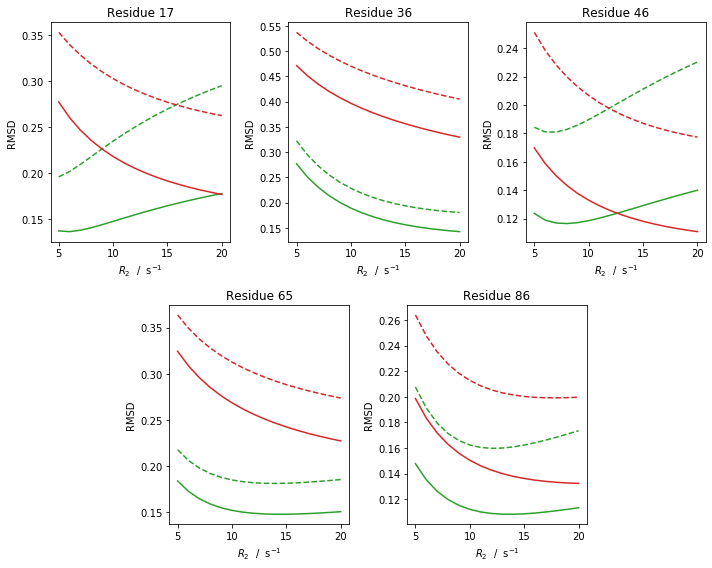

In [57]:
ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2, fig=plt.figure(figsize=(10,8)))
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)
axes = [ax1,ax2,ax3,ax4,ax5]
for ax,label in zip(axes,labels):
    r_2,chi2 = np.loadtxt('chi2r_2/chi2RLA{:d}.dat'.format(label),unpack=True)
    ax.plot(r_2,np.sqrt(chi2), color=plt.cm.tab10(2), label='RLA')
    r_2,chi2 = np.loadtxt('chi2r_2/chi2RLADynRange{:d}.dat'.format(label),unpack=True)
    ax.plot(r_2,np.sqrt(chi2), color=plt.cm.tab10(2), ls='--', label='RLA dyn. range')
    r_2,chi2 = np.loadtxt('chi2r_2/chi2Cbeta{:d}.dat'.format(label),unpack=True)
    ax.plot(r_2,np.sqrt(chi2), color=plt.cm.tab10(3), label=r'C$\beta$')
    r_2,chi2 = np.loadtxt('chi2r_2/chi2CbetaDynRange{:d}.dat'.format(label),unpack=True)
    ax.plot(r_2,np.sqrt(chi2), color=plt.cm.tab10(3), ls='--', label=r'C$\beta$ dyn. range')
    ax.set_title('Residue {:d}'.format(label))
    ax.set_xlabel(r'$R_2$  /  s$^{-1}$')
    ax.set_ylabel(r'RMSD')
plt.tight_layout(w_pad=1.5)
plt.savefig('figs/figS3.pdf')